# RACCAM studies using Zgoubidoo

In [38]:
import copy
import numpy as np
from zgoubidoo.commands import *
from zgoubidoo import ureg as _ureg

## Define the beam properties

### Kinematics

In [39]:
kin_nom = zgoubidoo.Kinematics(180 * _ureg.MeV)

kin_min = zgoubidoo.Kinematics(17 * _ureg.MeV)
kin_max = zgoubidoo.Kinematics(180 * _ureg.MeV)

DR_min = (kin_min.brho / kin_nom.brho).magnitude
DR_max = (kin_max.brho / kin_nom.brho).magnitude

### Beam

In [40]:
ref_beam = Objet2("BUNCH", BORO=kin_nom.brho)
ref_beam.add(np.array([[0, 0, 0, 0, 1.0]]));

## Create the spiral FFAG magnet

### Set the parameters as in the reference

In [41]:
NCells = 8
FieldIndex = 4.415
SpiralAngle = 50.36
Radius = 3.48 * _ureg.m
BField = 1.5
BendAngle = 45 * _ureg.degrees
SectorAngle = 17.1
Kappa = -1
Gap = 3
Omega_E = np.degrees(-0.6)
Omega_S = BendAngle.m_as("degrees")

In [42]:
ffa_cell = FFAGSpirale(
    "MY-FFAG-SPI",
    IL=2,
    N=1,  # One magnet in the Zgoubi element
    AT=BendAngle,
    RM=Radius,
    BZ0=[BField] * _ureg.tesla,
    ACN=[11.459155902616462] * _ureg.degrees,
    K=[FieldIndex],
    K_E=[Kappa],
    K_S=[Kappa],
    C0_E=[0.1455],
    C1_E=[2.267],
    C2_E=[-0.6395],
    C3_E=[1.1558],
    C0_S=[0.1455],
    C1_S=[2.267],
    C2_S=[-0.6395],
    C3_S=[1.1558],
    OMEGA_E=[SectorAngle / 2] * _ureg.degree,
    XI_E=[SpiralAngle] * _ureg.degree,
    OMEGA_S=[-SectorAngle / 2] * _ureg.degree,
    XI_S=[SpiralAngle] * _ureg.degree,
    G0_E=[Gap] * _ureg.cm,
    G0_S=[Gap] * _ureg.cm,
    KIRD=2,
    APERTURE_LEFT=10 * _ureg.cm,
    APERTURE_RIGHT=80 * _ureg.cm,
    POLE_WIDTH=200 * _ureg.cm,
)

### Create the Zgoubi input

In [43]:
zi = zgoubidoo.Input(
    name="SPIRAL",
    line=[
        ref_beam,
        ffa_cell,
    ],
)
zi.XPAS = 5 * _ureg.mm
zi.survey(reference_frame=zgoubidoo.Frame(), with_reference_trajectory=True, reference_kinematics=kin_nom);

### Plotting

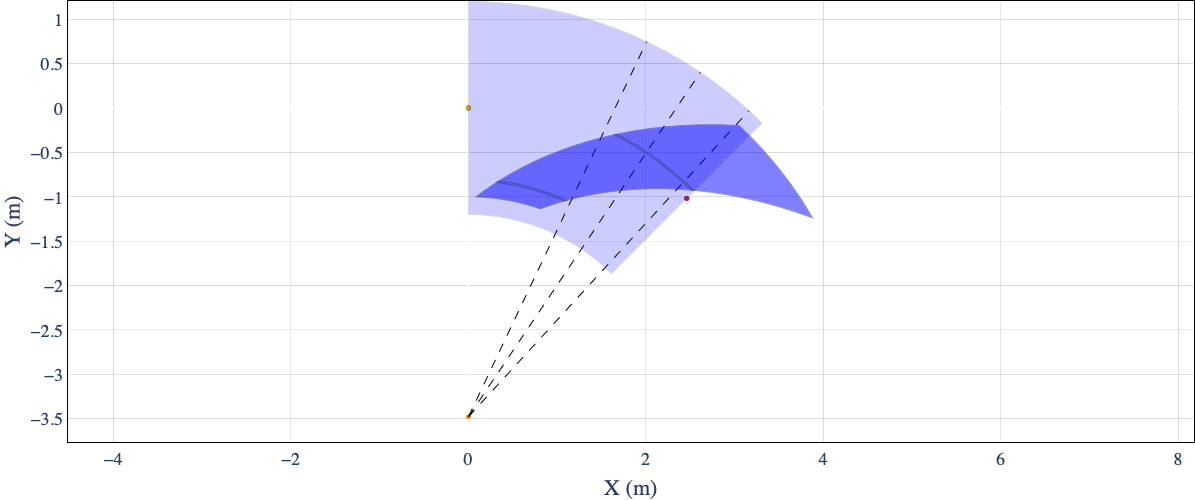

In [44]:
artist = zgoubidoo.vis.ZgoubidooPlotlyArtist()
artist.fig["layout"]["xaxis"]["title"] = "X (m)"
artist.fig["layout"]["yaxis"]["title"] = "Y (m)"
artist.fig["layout"]["width"] = 600
artist.fig["layout"]["height"] = 500

artist.fig["layout"]["margin"] = dict(l=0, r=0, b=0, t=0)
artist.fig["layout"]["yaxis"]["scaleanchor"] = "x"
artist.fig["layout"]["yaxis"]["scaleratio"] = 1

artist.plot_beamline(beamline=zi, with_frames=True, with_apertures=True, with_map=True)
artist.render()

## Perform a fit to find all closed orbits

In [45]:
fit = Fit2(
    "MY_FIT",
    PENALTY=1e-9,
    ITERATIONS=9999,
    PARAMS=[
        Fit2.Parameter(line=zi, place="BUNCH", parameter=Objet2.Y_, parameter_range=[-1000.0, 1000.0]),
        Fit2.Parameter(line=zi, place="BUNCH", parameter=Objet2.T_, parameter_range=[-1500.0, 1500.0]),
    ],
    CONSTRAINTS=[
        Fit2.DifferenceEqualityConstraint(line=zi, place="#End", variable=Fit2.FitCoordinates.Y, value=0.0),
        Fit2.DifferenceEqualityConstraint(line=zi, place="#End", variable=Fit2.FitCoordinates.T, value=0.0),
    ],
);

In [46]:
zi = zgoubidoo.Input(name="SPIRAL", line=[ref_beam, ffa_cell, fit])
zi.XPAS = 5 * _ureg.mm
zi.survey(reference_frame=zgoubidoo.Frame(), with_reference_trajectory=True, reference_kinematics=kin_nom);

### Get the closed orbits

In [47]:
energies = [17, 32, 60, 107, 180]
dr_vals = [(zgoubidoo.Kinematics(i * _.MeV).brho / kin_nom.brho).magnitude for i in energies]

In [48]:
orbits = []
fit.clean_output_and_results()

y0, t0 = -50 * _.cm, 100 * _.mrad

i = 0
for dr in dr_vals:
    ref_beam = Objet2("BUNCH", BORO=kin_nom.brho)
    ref_beam.add(np.array([[y0.magnitude, t0.magnitude, 0, 0, dr]]))
    zi.replace("BUNCH", ref_beam)
    zr = zgoubidoo.Zgoubi()(zi).collect()
    # Use the previous values for the fit
    y0 = fit.results[i][1].results.at[1, "final"]
    t0 = fit.results[i][1].results.at[2, "final"]
    orbits.append([y0.magnitude, t0.magnitude, 0, 0, dr])

    res = float(fit.output[i][1][-1].replace(" Fit reached penalty value   ", ""))

    print(f"Closed orbit for dr = {dr}: y={y0.magnitude}, t={t0.magnitude}, res={res}")
    i += 1

Closed orbit for dr = 0.29488786857158916: y=-80.182929, t=84.4886, res=1.235e-10
Closed orbit for dr = 0.40618213927125807: y=-64.857619, t=13.110447, res=3.6851e-10
Closed orbit for dr = 0.5602528244589301: y=-47.04262, t=-58.57568, res=3.6805e-10
Closed orbit for dr = 0.7571946782811589: y=-27.844895, t=-125.72438, res=8.2468e-10
Closed orbit for dr = 1.0: y=-7.6516197, t=-187.72421, res=3.1758e-10


In [49]:
results_tracking = []
zi = zgoubidoo.Input(name="SPIRAL", line=[ref_beam, ffa_cell])
zi.survey(reference_frame=zgoubidoo.Frame(), with_reference_trajectory=True, reference_kinematics=kin_nom);
zi.XPAS = 5 * _ureg.mm
for i, orb in enumerate(orbits):
    ref_beam = Objet2("BUNCH", BORO=kin_nom.brho)
    ref_beam.add(np.array([orb]))
    zi.replace("BUNCH", ref_beam)
    zr = zgoubidoo.Zgoubi()(zi).collect()

    results_tracking.append([orbits[i][4], zr])

### Plotting

In [50]:
layout = zgoubidoo.vis.ZgoubidooPlotlyArtist().layout
colors = ["red", "blue", "green", "magenta", "darkorange"]

ERROR:root:You should do a survey: 
zgoubidoo.survey(beamline=zi, reference_frame=zgoubidoo.Frame(), with_reference_trajectory=True, reference_kinematics=k)


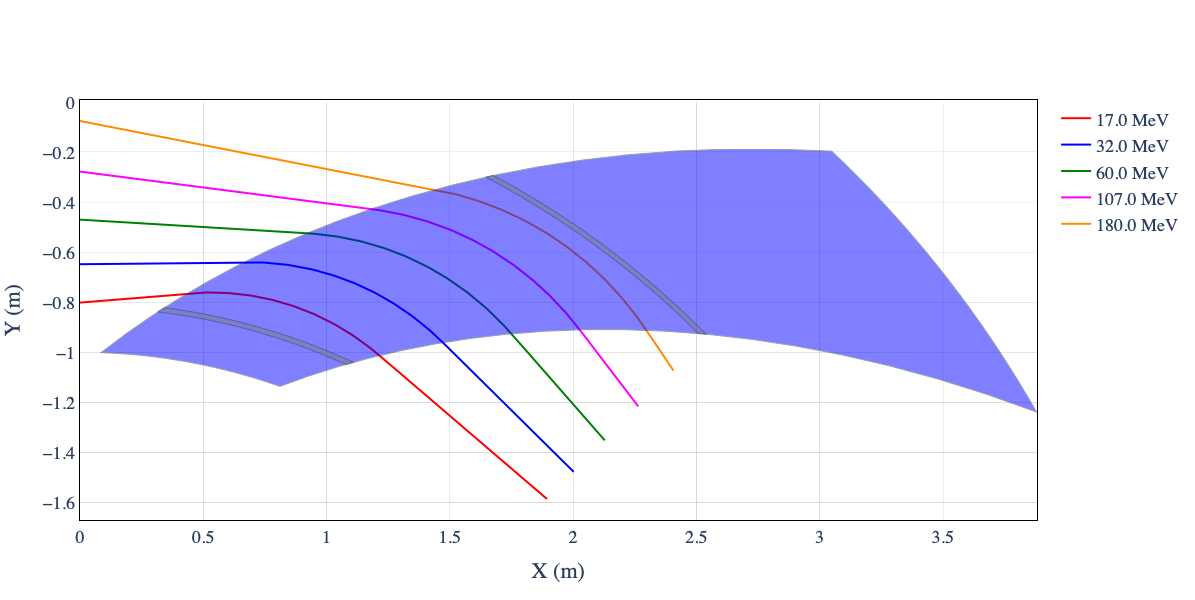

In [51]:
artist = zgoubidoo.vis.ZgoubidooPlotlyArtist(layout=layout)

artist.fig["layout"]["xaxis"]["title"] = "X (m)"
artist.fig["layout"]["yaxis"]["title"] = "Y (m)"


for i, results in enumerate(results_tracking):
    ekin = np.round(zgoubidoo.Kinematics(kin_nom.brho * results[0]).ekin.m_as("MeV"), 2)
    artist.scatter(
        x=results[1].tracks_global["XG"],
        y=results[1].tracks_global["YG"],
        line={"width": 2, "color": colors[i]},
        mode="lines",
        name=f"{np.round(ekin,2)} MeV",
    )

artist.plot_beamline(beamline=zi, with_frames=False, with_apertures=True, with_map=False)
artist.render()

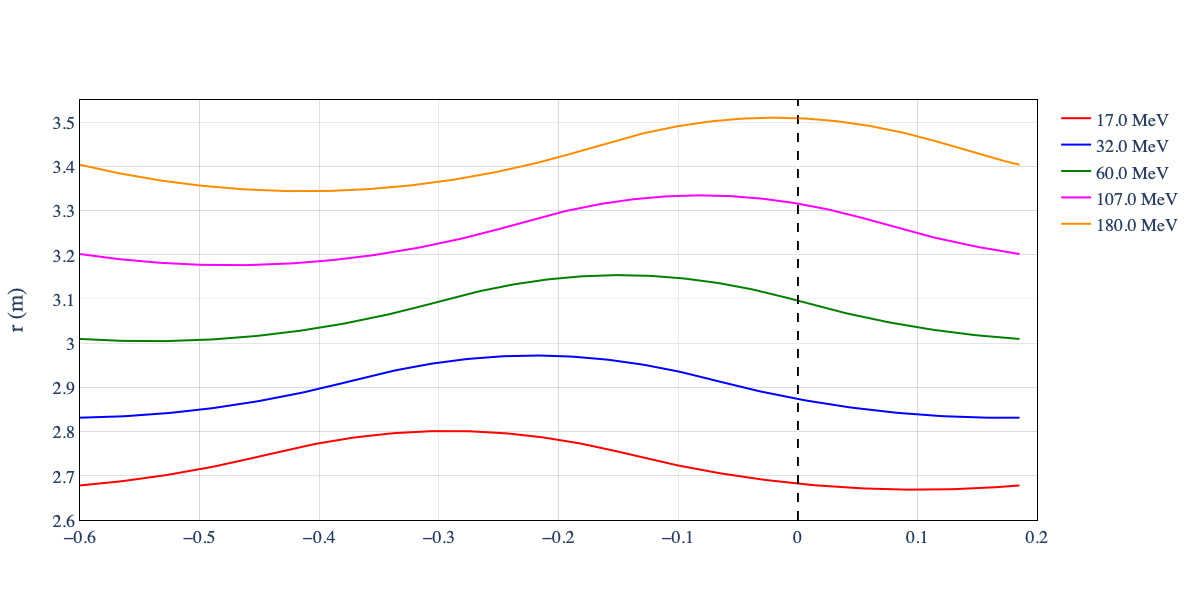

In [52]:
artist = zgoubidoo.vis.ZgoubidooPlotlyArtist(layout=layout)

artist.fig["layout"]["xaxis"]["title"] = r"$\theta \text{ (rad)}$"
artist.fig["layout"]["yaxis"]["title"] = "r (m)"
artist.fig["layout"]["xaxis"]["range"] = [-0.6, 0.2]
artist.fig["layout"]["yaxis"]["range"] = [2.6, 3.55]


for i, results in enumerate(results_tracking):
    ekin = np.round(zgoubidoo.Kinematics(kin_nom.brho * results[0]).ekin.m_as("MeV"), 2)
    theta = results[1].tracks_frenet["ANGLE"].values - 0.6
    radius = results[1].tracks_frenet["R"].values
    radius = np.concatenate([radius, radius])

    artist.scatter(
        x=theta,
        y=radius,
        line={"width": 2, "color": colors[i]},
        mode="lines",
        name=f"{np.round(ekin,2)} MeV",
    )

    artist.scatter(
        x=[np.radians(0), np.radians(0)],
        y=[2.6, 4],
        line={"color": "black", "dash": "dash", "width": 1.2},
        mode="lines",
        showlegend=False,
    )

artist.render()

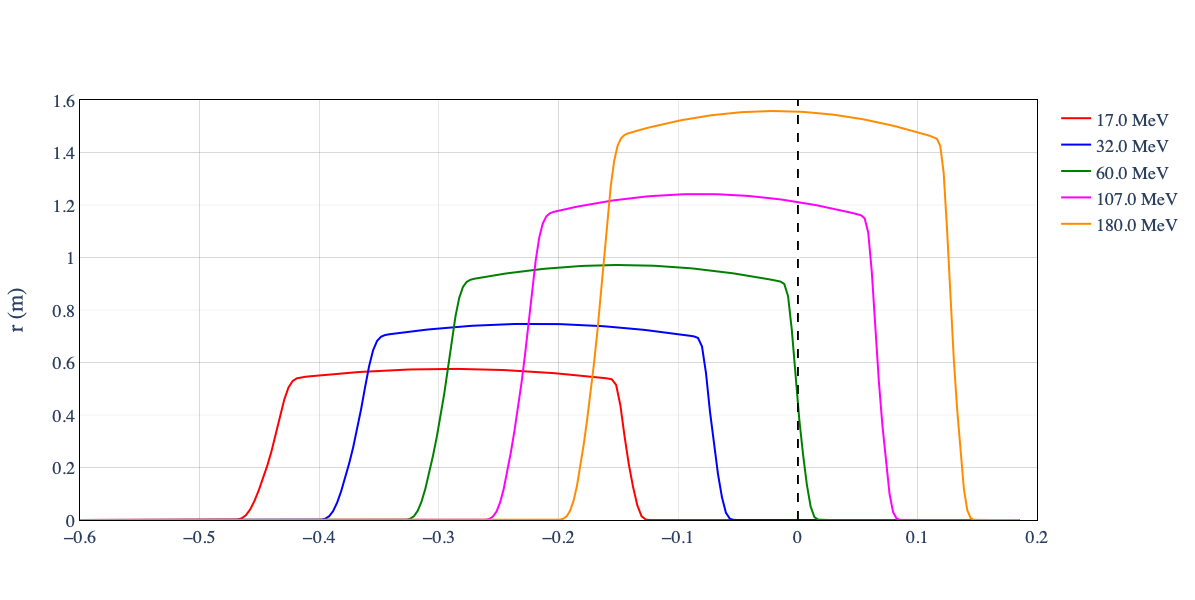

In [53]:
artist = zgoubidoo.vis.ZgoubidooPlotlyArtist(layout=layout)

artist.fig["layout"]["xaxis"]["title"] = r"$\theta \text{ (rad)}$"
artist.fig["layout"]["yaxis"]["title"] = "r (m)"
artist.fig["layout"]["xaxis"]["range"] = [-0.6, 0.2]
artist.fig["layout"]["yaxis"]["range"] = [0, 1.6]


for i, results in enumerate(results_tracking):
    ekin = np.round(zgoubidoo.Kinematics(kin_nom.brho * results[0]).ekin.m_as("MeV"), 2)
    theta = results[1].tracks_frenet["ANGLE"].values - 0.6

    artist.scatter(
        x=theta,
        y=results[1].tracks_frenet["BZ"] / 10,
        line={"width": 2, "color": colors[i]},
        mode="lines",
        name=f"{np.round(ekin,2)} MeV",
    )

    artist.scatter(
        x=[0, 0], y=[0, 1.6], line={"color": "black", "dash": "dash", "width": 1.2}, mode="lines", showlegend=False
    )

artist.render()

## Tracking in the ring

### Create the ring

In [54]:
zi = zgoubidoo.Input(
    name="SPIRAL",
    line=[
        ref_beam,
        ffa_cell,
        copy.copy(ffa_cell),
        copy.copy(ffa_cell),
        copy.copy(ffa_cell),
        copy.copy(ffa_cell),
        copy.copy(ffa_cell),
        copy.copy(ffa_cell),
        copy.copy(ffa_cell),
    ],
)
zi.XPAS = 5 * _ureg.mm
zi.IL = 2
zi.survey(reference_frame=zgoubidoo.Frame(), with_reference_trajectory=True, reference_kinematics=kin_nom);

In [55]:
results_ring = []
for i, orb in enumerate(orbits):
    ref_beam = Objet2("BUNCH", BORO=kin_nom.brho)
    ref_beam.add(np.array([orb]))
    zi.replace("BUNCH", ref_beam)
    zr = zgoubidoo.Zgoubi()(zi).collect()

    results_ring.append([orbits[i][4], zr])

### Plotting

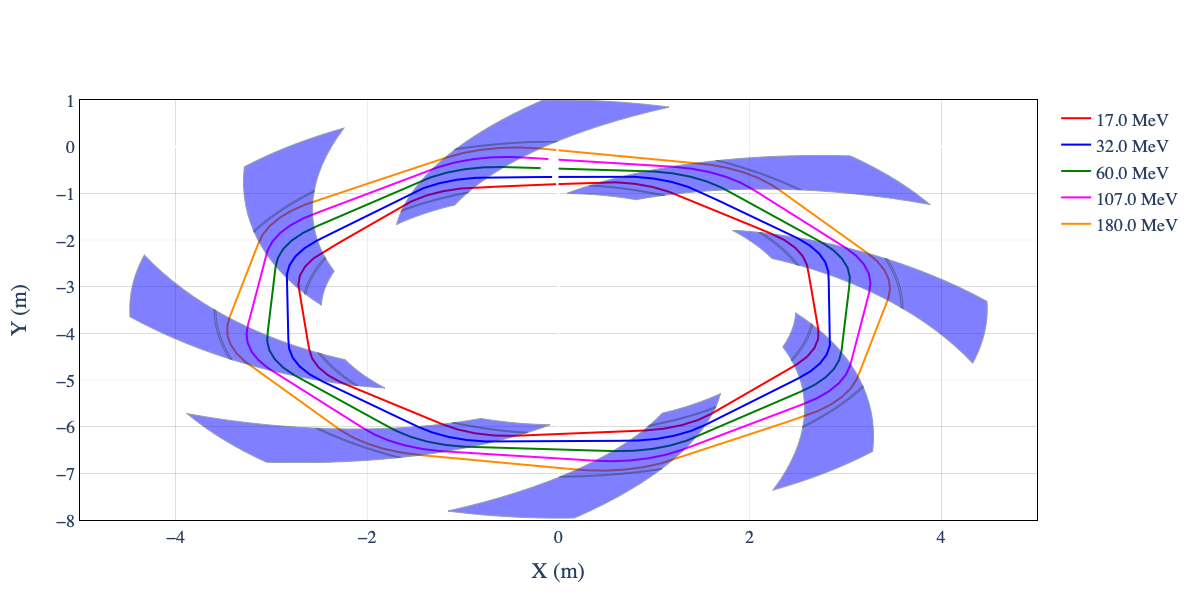

In [56]:
artist = zgoubidoo.vis.ZgoubidooPlotlyArtist(layout=layout)
artist.fig["layout"]["xaxis"]["title"] = "X (m)"
artist.fig["layout"]["yaxis"]["title"] = "Y (m)"
artist.fig["layout"]["xaxis"]["range"] = [-5, 5]
artist.fig["layout"]["yaxis"]["range"] = [-8, 1]

for i, results in enumerate(results_ring):
    ekin = np.round(zgoubidoo.Kinematics(kin_nom.brho * results[0]).ekin.m_as("MeV"), 2)
    artist.scatter(
        x=results[1].tracks_global["XG"][::20],
        y=results[1].tracks_global["YG"][::20],
        line={"width": 2, "color": colors[i]},
        mode="lines",
        name=f"{np.round(ekin,2)} MeV",
    )

artist.plot_beamline(beamline=zi, with_frames=False, with_apertures=True, with_map=False)
artist.render()

## Multiple turns tracking

In [57]:
zi = zgoubidoo.Input(
    name="SPIRAL",
    line=[
        ref_beam,
        Marker("A"),
        ffa_cell,
        copy.copy(ffa_cell),
        copy.copy(ffa_cell),
        copy.copy(ffa_cell),
        copy.copy(ffa_cell),
        copy.copy(ffa_cell),
        copy.copy(ffa_cell),
        copy.copy(ffa_cell),
        Rebelote(NPASS=125),
    ],
)
zi.XPAS = 5 * _ureg.mm
zi.IL = 0
zi.survey(reference_frame=zgoubidoo.Frame(), with_reference_trajectory=True, reference_kinematics=kin_nom);

### Horizontal dynamic aperture

In [58]:
delta_radius = np.array([2.5, 2.5, 2.5, 2.5, 2.5])

In [59]:
hor_offset = np.array(
    [
        [orbits[0][0] + delta_radius[0], orbits[0][1], orbits[0][2], orbits[0][3], orbits[0][4]],
        [orbits[1][0] + delta_radius[1], orbits[1][1], orbits[1][2], orbits[1][3], orbits[1][4]],
        [orbits[2][0] + delta_radius[2], orbits[2][1], orbits[2][2], orbits[2][3], orbits[2][4]],
        [orbits[3][0] + delta_radius[3], orbits[3][1], orbits[3][2], orbits[3][3], orbits[3][4]],
        [orbits[4][0] + delta_radius[4], orbits[4][1], orbits[4][2], orbits[4][3], orbits[4][4]],
    ]
)

In [60]:
beam_offset = BeamInputDistribution("BUNCH", distribution=hor_offset, kinematics=kin_nom, slices=5)

In [61]:
zi.replace("BUNCH", beam_offset)
zr = zgoubidoo.Zgoubi()(zi).collect()

### Plotting

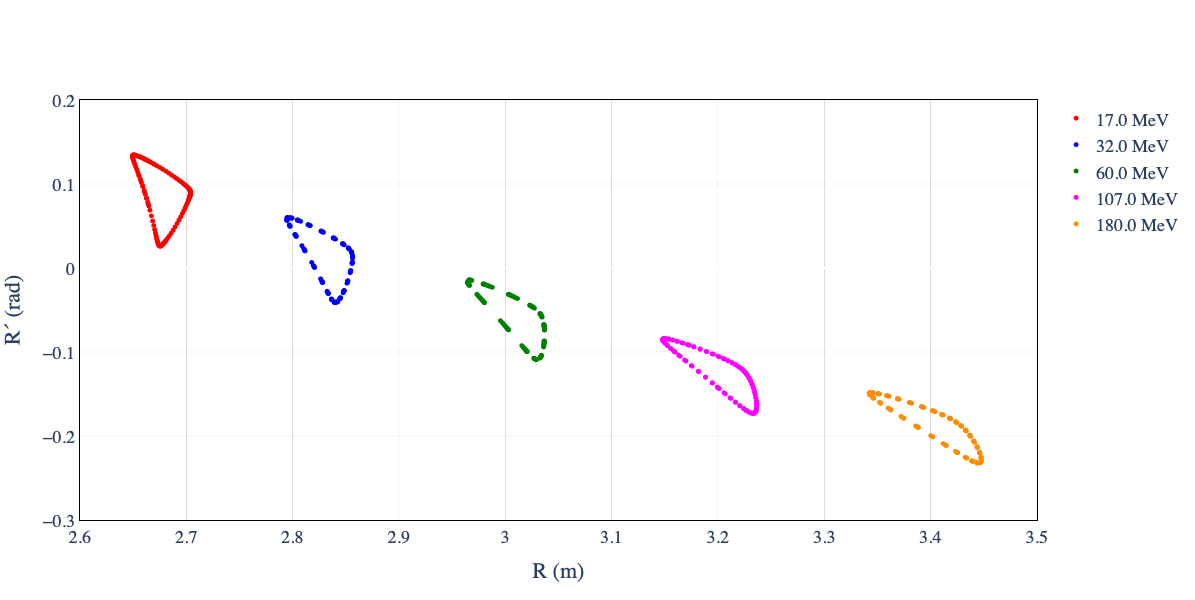

In [62]:
artist = zgoubidoo.vis.ZgoubidooPlotlyArtist(layout=layout)

artist.fig["layout"]["xaxis"]["title"] = "R (m)"
artist.fig["layout"]["yaxis"]["title"] = "R´ (rad)"
artist.fig["layout"]["xaxis"]["range"] = [2.6, 3.5]
artist.fig["layout"]["yaxis"]["range"] = [-0.3, 0.2]

tracks = zr.tracks_frenet
tracks.query("LABEL1 == 'A'", inplace=True)
idx = 0
for i in tracks["D-1"].unique():
    ekin = zgoubidoo.Kinematics(kin_nom.brho * (i + 1)).ekin.m_as("MeV")
    artist.scatter(
        x=ffa_cell.RM.m_as("m") + tracks[tracks["D-1"] == i]["Y"],
        y=tracks[tracks["D-1"] == i]["T"],
        name=f"{np.round(ekin,2)} MeV",
        mode="markers",
        marker={"size": 5, "color": colors[idx]},
    )
    idx += 1


artist.render()

### Vertical dynamic aperture

In [63]:
ver_offset = np.array(
    [
        [orbits[0][0], orbits[0][1], orbits[0][2] + 0.7, orbits[0][3], orbits[0][4]],
        [orbits[1][0], orbits[1][1], orbits[1][2] + 1.0, orbits[1][3], orbits[1][4]],
        [orbits[2][0], orbits[2][1], orbits[2][2] + 1.0, orbits[2][3], orbits[2][4]],
        [orbits[3][0], orbits[3][1], orbits[3][2] + 1.0, orbits[3][3], orbits[3][4]],
        [orbits[4][0], orbits[4][1], orbits[4][2] + 1.0, orbits[4][3], orbits[4][4]],
    ]
)

In [64]:
beam_offset = BeamInputDistribution("BUNCH", distribution=ver_offset, kinematics=kin_nom, slices=5)

In [65]:
zi.replace("BUNCH", beam_offset)
zr = zgoubidoo.Zgoubi()(zi).collect()

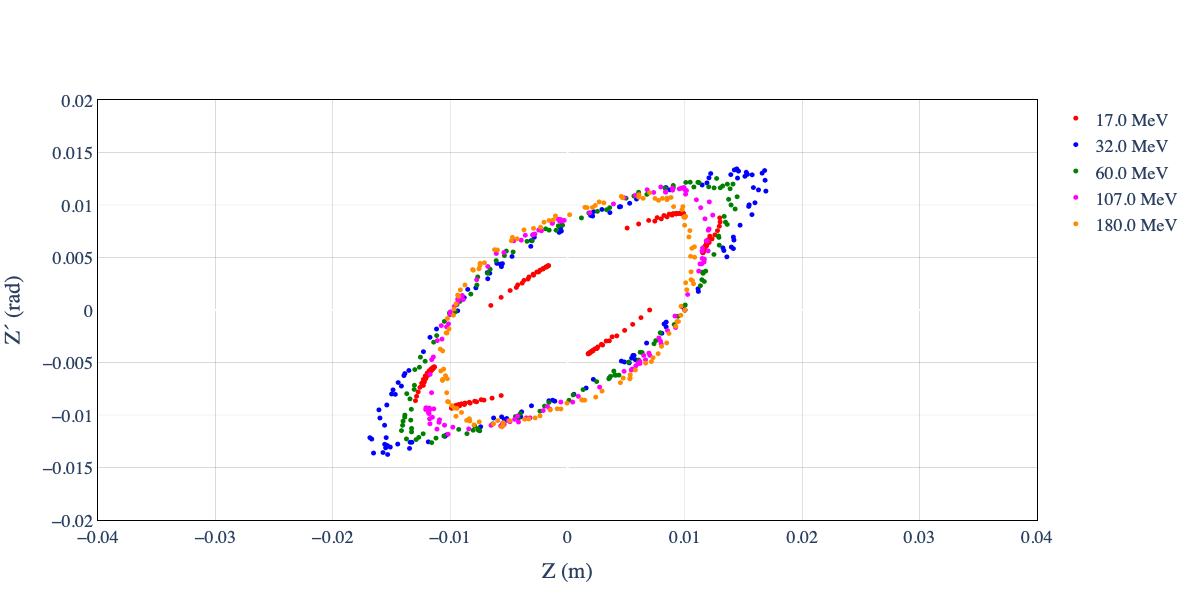

In [66]:
artist = zgoubidoo.vis.ZgoubidooPlotlyArtist(layout=layout)

artist.fig["layout"]["xaxis"]["title"] = "Z (m)"
artist.fig["layout"]["yaxis"]["title"] = "Z´ (rad)"
artist.fig["layout"]["xaxis"]["range"] = [-0.04, 0.04]
artist.fig["layout"]["yaxis"]["range"] = [-0.02, 0.02]

tracks = zr.tracks_frenet
tracks.query("LABEL1 == 'A'", inplace=True)
idx = 0
for i in tracks["D-1"].unique():
    ekin = zgoubidoo.Kinematics(kin_nom.brho * (i + 1)).ekin.m_as("MeV")
    artist.scatter(
        x=tracks[tracks["D-1"] == i]["ZT"],
        y=tracks[tracks["D-1"] == i]["P"],
        name=f"{np.round(ekin,2)} MeV",
        mode="markers",
        marker={"size": 5, "color": colors[idx]},
    )
    idx += 1


artist.render()

## Maximum stable amplitude @60 MeV

In [67]:
hor_offset = np.array(
    [
        [orbits[2][0] + 0.2, orbits[2][1], orbits[2][2], orbits[2][3], orbits[2][4]],
        [orbits[2][0] + 0.5, orbits[2][1], orbits[2][2], orbits[2][3], orbits[2][4]],
        [orbits[2][0] + 1.0, orbits[2][1], orbits[2][2], orbits[2][3], orbits[2][4]],
        [orbits[2][0] + 1.5, orbits[2][1], orbits[2][2], orbits[2][3], orbits[2][4]],
        [orbits[2][0] + 2, orbits[2][1], orbits[2][2], orbits[2][3], orbits[2][4]],
        [orbits[2][0] + 2.5, orbits[2][1], orbits[2][2], orbits[2][3], orbits[2][4]],
    ]
)

In [68]:
beam_offset = BeamInputDistribution("BUNCH", distribution=hor_offset, kinematics=kin_nom, slices=6)

In [ ]:
zi.replace("BUNCH", beam_offset)
zr = zgoubidoo.Zgoubi()(zi).collect()

In [ ]:
artist = zgoubidoo.vis.ZgoubidooPlotlyArtist(layout=layout)

artist.fig["layout"]["xaxis"]["title"] = "X (m)"
artist.fig["layout"]["yaxis"]["title"] = "X´ (rad)"
artist.fig["layout"]["xaxis"]["range"] = [2.96, 3.04]
artist.fig["layout"]["yaxis"]["range"] = [-0.1, -0.02]

tracks = zr.tracks_frenet
tracks.query("LABEL1 == 'A'", inplace=True)
artist.scatter(
    x=ffa_cell.RM.m_as("m") + tracks["Y"], y=tracks["T"], mode="markers", marker={"size": 5, "color": "blue"}
)
artist.render()

In [ ]:
ver_offset = np.array(
    [
        [orbits[2][0], orbits[2][1], orbits[2][2], orbits[2][3], orbits[2][4]],
        [orbits[2][0], orbits[2][1], orbits[2][2] + 0.2, orbits[2][3], orbits[2][4]],
        [orbits[2][0], orbits[2][1], orbits[2][2] + 0.5, orbits[2][3], orbits[2][4]],
        [orbits[2][0], orbits[2][1], orbits[2][2] + 0.7, orbits[2][3], orbits[2][4]],
        [orbits[2][0], orbits[2][1], orbits[2][2] + 1.0, orbits[2][3], orbits[2][4]],
    ]
)

In [ ]:
beam_offset = BeamInputDistribution("BUNCH", distribution=ver_offset, kinematics=kin_nom, slices=5)

In [ ]:
zi.replace("BUNCH", beam_offset)
zr = zgoubidoo.Zgoubi()(zi).collect()

In [ ]:
artist = zgoubidoo.vis.ZgoubidooPlotlyArtist(layout=layout)

artist.fig["layout"]["xaxis"]["title"] = "Z (m)"
artist.fig["layout"]["yaxis"]["title"] = "Z´ (rad)"
artist.fig["layout"]["xaxis"]["range"] = [-0.03, 0.03]
artist.fig["layout"]["yaxis"]["range"] = [-0.015, 0.015]

tracks = zr.tracks_frenet
tracks.query("LABEL1 == 'A'", inplace=True)
artist.scatter(x=tracks["Z"], y=tracks["P"], mode="markers", marker={"size": 5, "color": "blue"})
artist.render()